In [1]:
!pip install cython
!pip install tslearn

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import os
%matplotlib inline

def create_connection():
    host = 'localhost'
    port = '3333'
    return create_engine("postgresql://infocup@{}:{}/infocup".format(host,port))

In [3]:
con = create_connection()

active_stations = pd.read_sql_query("""SELECT station_id,time_stamp, price 
FROM prices_sampled 
WHERE price > 0 AND station_id <= 1000 AND date_part('hour', time_stamp)::int %% 8 = 0
AND time_stamp >= '2017-06-01'""", con)
#active_stations['time_stamp'] = active_stations['time_stamp'].astype(np.int64) // 10**9
active_stations.tail(10)

,station_id,time_stamp,price
323874,1000,2017-09-18 16:00:00,1309
323875,1000,2017-09-19 00:00:00,1409
323876,1000,2017-09-19 08:00:00,1389
323877,1000,2017-09-19 16:00:00,1309
323878,1000,2017-09-20 00:00:00,1419
323879,1000,2017-09-20 08:00:00,1389
323880,1000,2017-09-20 16:00:00,1309
323881,1000,2017-09-21 00:00:00,1419
323882,1000,2017-09-21 08:00:00,1379
323883,1000,2017-09-21 16:00:00,1329


In [4]:
active_stations = active_stations[np.isfinite(active_stations['price'])]
active_stations.dropna(inplace=True)
#prices_pivoted = active_stations.pivot_table(index='time_stamp', columns='station_id', values='price',fill_value=0)


# Remove Trend

In [5]:
active_stations['price'] = np.log(active_stations.price)
active_stations.head()

,station_id,time_stamp,price
0,1,2017-06-01 00:00:00,7.264730
1,1,2017-06-01 08:00:00,7.236339
2,1,2017-06-01 16:00:00,7.207119
3,1,2017-06-02 00:00:00,7.264730
4,1,2017-06-02 08:00:00,7.250636


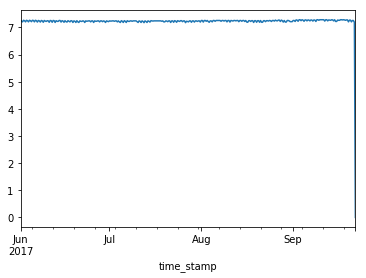

In [6]:
prices_pivoted = active_stations.pivot_table(index='time_stamp', columns='station_id', values='price',fill_value=0)
ts = pd.Series(prices_pivoted[1])
ts.plot()

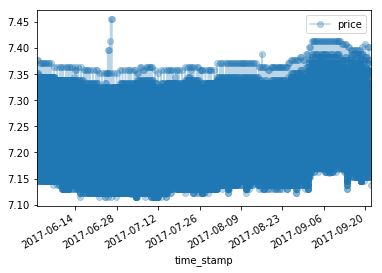

In [7]:
active_stations.plot.line(x=active_stations.time_stamp, y='price', marker='o', alpha=0.3)


# Modell to predict values

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
t_min, t_max = 0, 30
resolution = 0.1

ts = pd.Series(prices_pivoted[1])
ts.values.reshape(-1,20,1)

def next_batch(batch_size, n_steps,iteration):
    TS = np.array(ts)
    x_data = TS[:(len(TS)+iteration-len(TS)%n_steps)+iteration]
    x_batches = x_data.reshape(-1,20,1)
    y_data = TS[:(len(TS)-len(TS)%n_steps)+iteration + 1]
    y_batches = x_data.reshape(-1,20,1)
    return x_batches,y_batches



reset_graph()
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32,[None, n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None, n_steps,n_outputs])
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons,
                                                                          activation=tf.nn.relu), output_size=n_outputs)

#cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(n_neurons),tf.contrib.rnn.BasicLSTMCell(n_neurons)])
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [32]:
learning_rate = 0.001
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
n_iterations = 10000
batch_size = 20
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps,iteration)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_batch[-2:-1]})



0 	MSE: 45.8279
100 	MSE: 2.34303
200 	MSE: 1.00536
300 	MSE: 0.413161
400 	MSE: 0.0352911
500 	MSE: 0.000368856
600 	MSE: 4.94833e-05
700 	MSE: 4.7025e-05
800 	MSE: 4.5642e-05
900 	MSE: 4.43218e-05
1000 	MSE: 0.00379537
1100 	MSE: 4.17134e-05
1200 	MSE: 4.02599e-05
1300 	MSE: 3.94573e-05
1400 	MSE: 3.98062e-05
1500 	MSE: 4.21687e-05
1600 	MSE: 3.65624e-05
1700 	MSE: 3.59032e-05
1800 	MSE: 0.000686706
1900 	MSE: 3.41536e-05
2000 	MSE: 3.32255e-05
2100 	MSE: 3.27438e-05
2200 	MSE: 0.0144066
2300 	MSE: 3.40207e-05
2400 	MSE: 3.25096e-05
2500 	MSE: 3.20748e-05
2600 	MSE: 3.1647e-05
2700 	MSE: 3.12596e-05
2800 	MSE: 3.20567e-05
2900 	MSE: 3.02902e-05
3000 	MSE: 9.53686e-05
3100 	MSE: 3.04365e-05
3200 	MSE: 4.23725e-05
3300 	MSE: 3.0502e-05
3400 	MSE: 2.95785e-05
3500 	MSE: 3.15994e-05
3600 	MSE: 3.22921e-05
3700 	MSE: 3.00349e-05
3800 	MSE: 2.96663e-05
3900 	MSE: 2.92818e-05
4000 	MSE: 0.00209942
4100 	MSE: 2.94165e-05
4200 	MSE: 2.89311e-05
4300 	MSE: 2.85183e-05
4400 	MSE: 0.000401496
45

In [19]:
np.exp(pd.Series(y_pred.reshape(1,-1)[0]))

0     1474.625366
1     1451.671387
2     1421.061035
3     1455.317627
4     1454.695312
5     1452.390747
6     1453.496460
7     1453.448730
8     1393.301514
9     1449.999268
10    1454.206421
11    1394.670776
12    1441.273682
13    1435.189331
14    1419.347656
15    1451.674805
16    1440.754883
17    1391.926270
18    1452.330566
19    1367.197876
dtype: float32